In [1]:
# Setup notebook
from learntools.time_series.style import *  # plot style settings

import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

dtype = {
    'store_nbr': 'category',
    'family': 'category',
    'sales': 'float32',
    'onpromotion': 'uint64',
}
plot_params = dict(
    color="0.75",
    style=".-",
    markeredgecolor="0.25",
    markerfacecolor="0.25",
    legend=False,
)
store_sales = pd.read_csv(
    'store-sales-time-series-forecasting\\train.csv',
    dtype=dtype,
    parse_dates=['date'],
    infer_datetime_format=True,
)

store_sales = store_sales.set_index('date').to_period('D')
store_sales = store_sales.set_index(['store_nbr', 'family'], append=True)
average_sales = store_sales.groupby('date').mean()['sales']

average_sales

date
2013-01-01      1.409438
2013-01-02    278.390808
2013-01-03    202.840195
2013-01-04    198.911148
2013-01-05    267.873230
                 ...    
2017-08-11    463.733856
2017-08-12    444.798279
2017-08-13    485.768616
2017-08-14    427.004730
2017-08-15    427.980896
Freq: D, Name: sales, Length: 1684, dtype: float32

2) Identify trend

Bu derste ortalama satışların zaman serisini kullanmaya devam edeceğiz. Trendi tahmin eden ortalama_satışların hareketli bir ortalama grafiğini görmek için bu hücreyi çalıştırın.

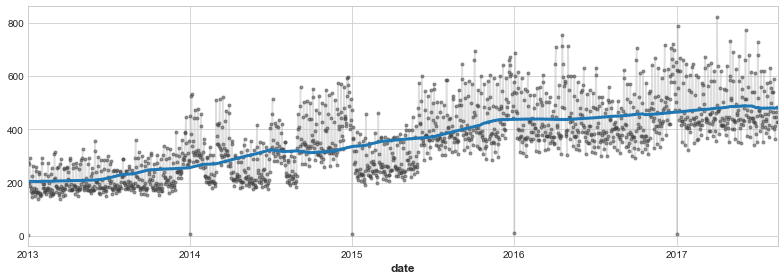

In [2]:
trend = average_sales.rolling(
    window=365,  # 365-day window
    center=True,  # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()  # compute the mean (could also do median, std, min, max, ...)

ax = average_sales.plot(**plot_params, alpha=0.5)
ax = trend.plot(ax=ax, linewidth=3)

3) Create a Trend Feature

Kübik bir trend modeli için bir özellik seti oluşturmak için DeterministicProcess'i kullanın. Ayrıca 90 günlük bir tahmin için özellikler oluşturun.

In [3]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = average_sales.copy()  # the target

# YOUR CODE HERE: Instantiate `DeterministicProcess` with arguments
# appropriate for a cubic trend model
dp = DeterministicProcess(
    index=y.index,
    #constant=True,
    order=3,
    #drop=True,
)

# YOUR CODE HERE: Create the feature set for the dates given in y.index
X = dp.in_sample()

# YOUR CODE HERE: Create features for a 90-day forecast.
X_fore = dp.out_of_sample(steps=90)

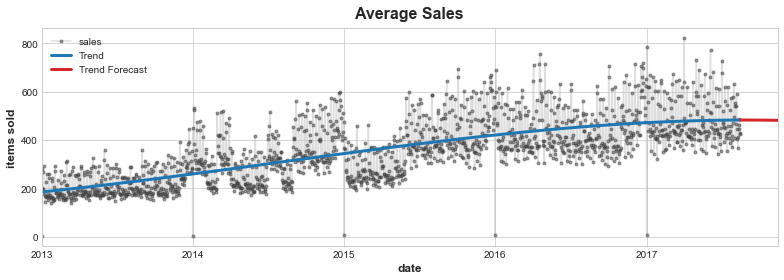

In [4]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

Daha karmaşık eğilimlere uymanın bir yolu, kullandığınız polinomun sırasını artırmaktır. Mağaza Satışlarındaki biraz karmaşık eğilime daha iyi uyum sağlamak için, bir sipariş 11 polinomu kullanmayı deneyebiliriz.

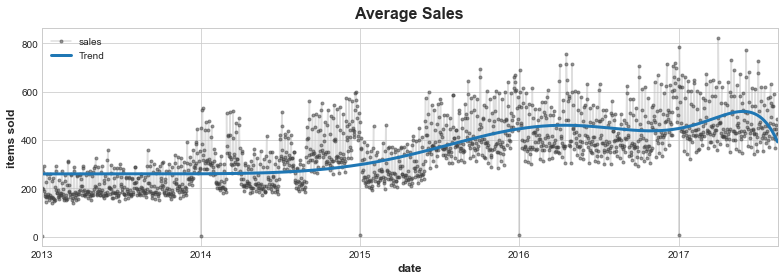

In [5]:
from statsmodels.tsa.deterministic import DeterministicProcess

dp = DeterministicProcess(index=y.index, order=11)
X = dp.in_sample()

model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax.legend();

4) Understand risks of forecasting with high-order polynomials
(Yüksek dereceli polinomlarla tahmin yapmanın risklerini anlayın)

Yüksek dereceli polinomlar genellikle tahmin için pek uygun değildir.
Bir sipariş 11 polinomu kullanarak aynı 90 günlük tahmini görmek için bu hücreyi çalıştırın.

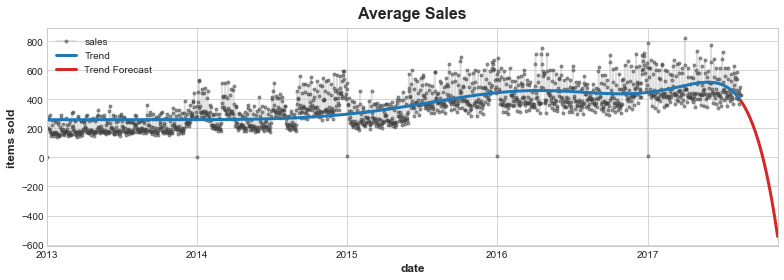

In [6]:
X_fore = dp.out_of_sample(steps=90)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

ax = y.plot(**plot_params, alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend", color='C0')
ax = y_fore.plot(ax=ax, linewidth=3, label="Trend Forecast", color='C3')
ax.legend();

(Optional) Fit trend with splines

Bir trende uymak istediğinizde spline'lar polinomlara güzel bir alternatiftir. pyearth kitaplığındaki Çok Değişkenli Uyarlamalı Regresyon Spline'ları (MARS) algoritması güçlü ve kullanımı kolaydır. Araştırmak isteyebileceğiniz birçok hiperparametre var.

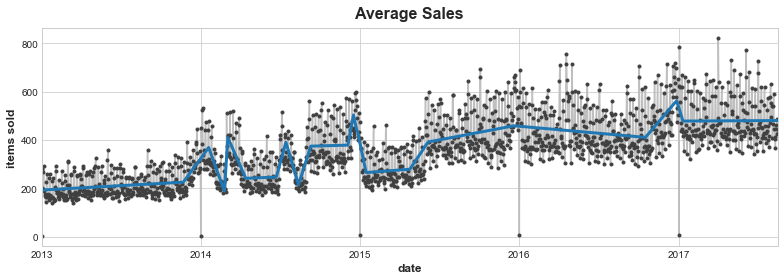

In [7]:
from pyearth import Earth

# Target and features are the same as before
y = average_sales.copy()
dp = DeterministicProcess(index=y.index, order=1)
X = dp.in_sample()

# Fit a MARS model with `Earth`
model = Earth()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)

ax = y.plot(**plot_params, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, linewidth=3, label="Trend")

Bunun gibi karmaşık eğilimleri tahmin etmek genellikle zor olacaktır (imkansız değilse). Bununla birlikte, geçmiş verilerle, bir zaman serisindeki diğer kalıpları trendden arındırarak izole etmek için spline'ları kullanabilirsiniz.

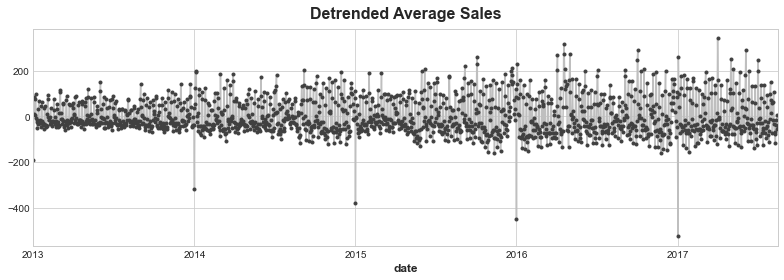

In [8]:
y_detrended = y - y_pred  # remove the trend from store_sales

y_detrended.plot(**plot_params, title="Detrended Average Sales");